# Train a regression network to predict the blur kernel radius






# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "BLUR_SHUFFLE1"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train blur kernel predictor shufflenet v1.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train blur kernel predictor shufflenet v1.ipynb
/media/SSD/superres/Results/Superresolution train blur kernel predictor shufflenet v1


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [37]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage, Normalize

import random

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers

torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:
#import fnmatch

In [10]:
from superres_utils import make_framelist, load_frame, RescaleCrop, Multifuz, DatasetFromVideoFolder
from superres_utils import show_batch
from superres_utils import pil_disk_blur, display_PSNR, test_results, superres_mp4

In [ ]:
# get a list of all the data
instances = make_framelist("/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR",1)

In [ ]:
#test the Multifuz transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
im = RescaleCrop(crop_size=(480,720),kernel_width=10)(im)
im_res = Multifuz(crop_size = (480,720),
                  center=(360,240),
                  kernel_a=2, 
                  kernel_b=10,
                  quality=np.int16(22), 
                  slope=.1,
                 radius=50,
                 scale=1)(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [44]:
def input_transform():        
    return Compose([        
        #Grayscale(num_output_channels=1),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])



def target_transform(crop_size):
    return Compose([
        #Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


In [45]:
train_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_train_HR"
#train_dir = "/home/filip/SSD_link/superres/video_data/train_data"
frame_sample_size =10
batch_size = 32 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (128,128)
kernel_range=(0,16)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=True
Rand_bright_contrast=True

In [46]:
train_set = DatasetFromVideoFolder(train_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10
                            )
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

In [47]:
valid_dir = "/home/filip/SSD_link/superres/DIV2K/DIV2K_valid_HR"
#frame_sample_size =10
#batch_size = 4 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)

kernel_range=(0,16)
quality_range=(30,99) 
slope_range=(0.001, 0.1)
radius_range=(0,0)  # make all one fuzziness
scale_range=(1/2,2)
Flip_hor=False
Rand_bright_contrast=False
match_exp = "*.*"

In [48]:
valid_set = DatasetFromVideoFolder(valid_dir,crop_size,frame_sample_size,
                                   input_transform=input_transform(),
                                   target_transform=target_transform(crop_size),
                                   Flip_hor=Flip_hor,
                                   Rand_bright_contrast=Rand_bright_contrast,
                                   kernel_range=kernel_range,
                                   quality_range=quality_range,
                                   slope_range=slope_range,
                                   radius_range=radius_range,
                                   scale_range=scale_range,
                                   max_kernel=10,
                                   match_exp=match_exp,
                            )
valid_data_loader = DataLoader(dataset=valid_set, num_workers=0, batch_size=batch_size, shuffle=False)

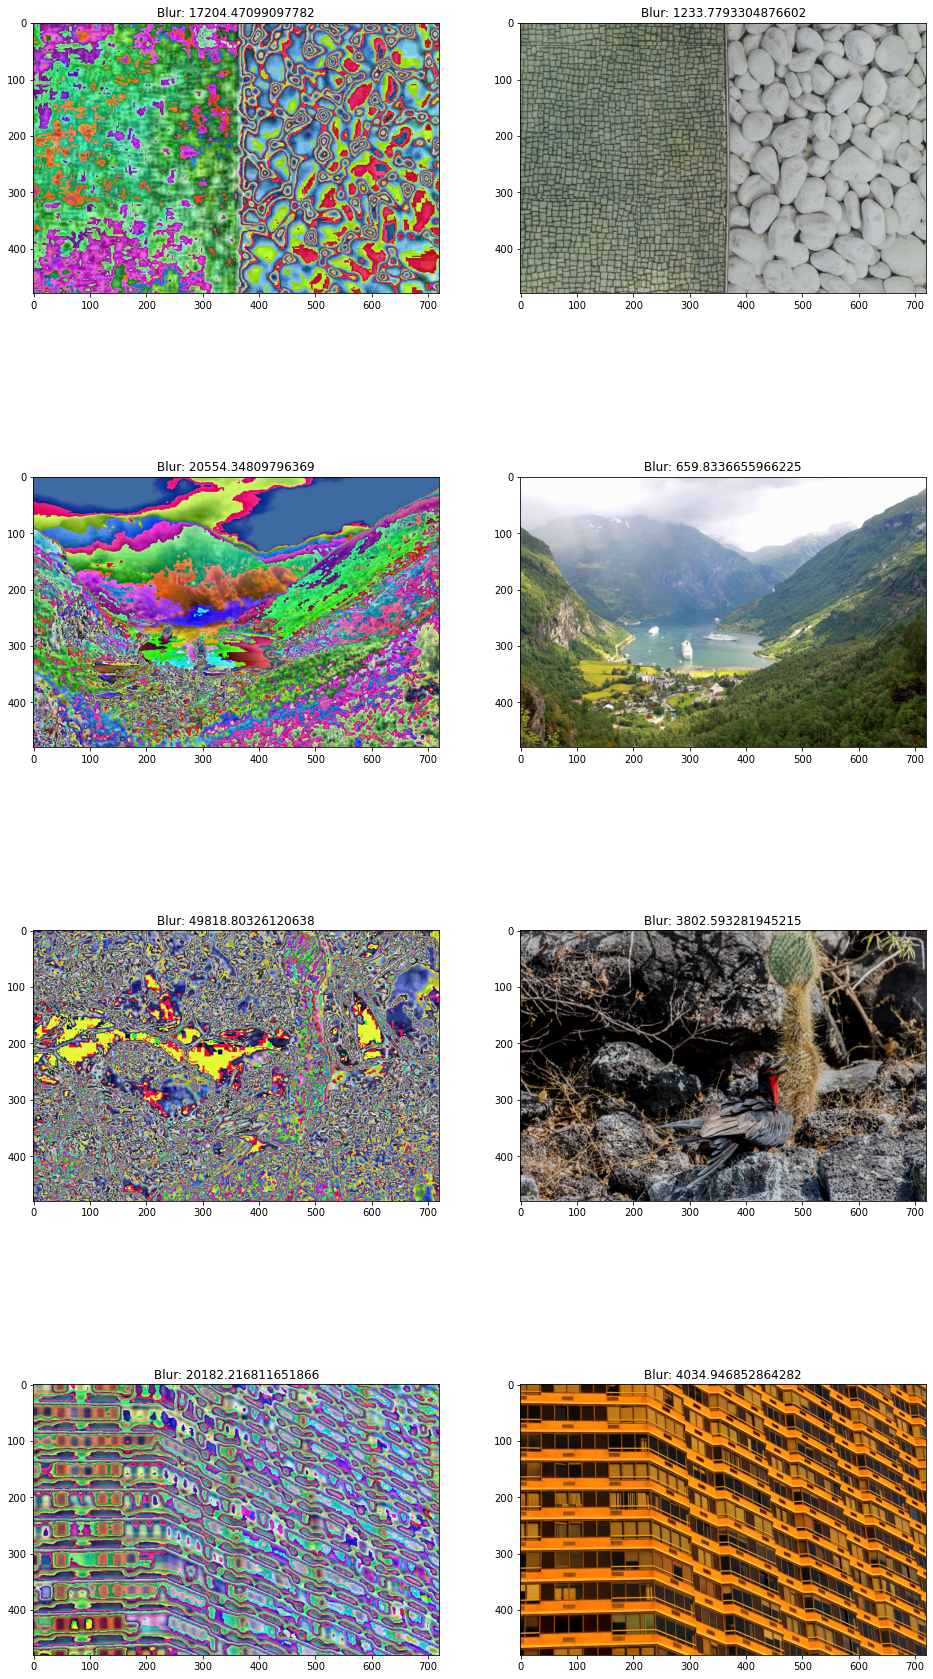

In [49]:
show_batch(training_data_loader,size =8)

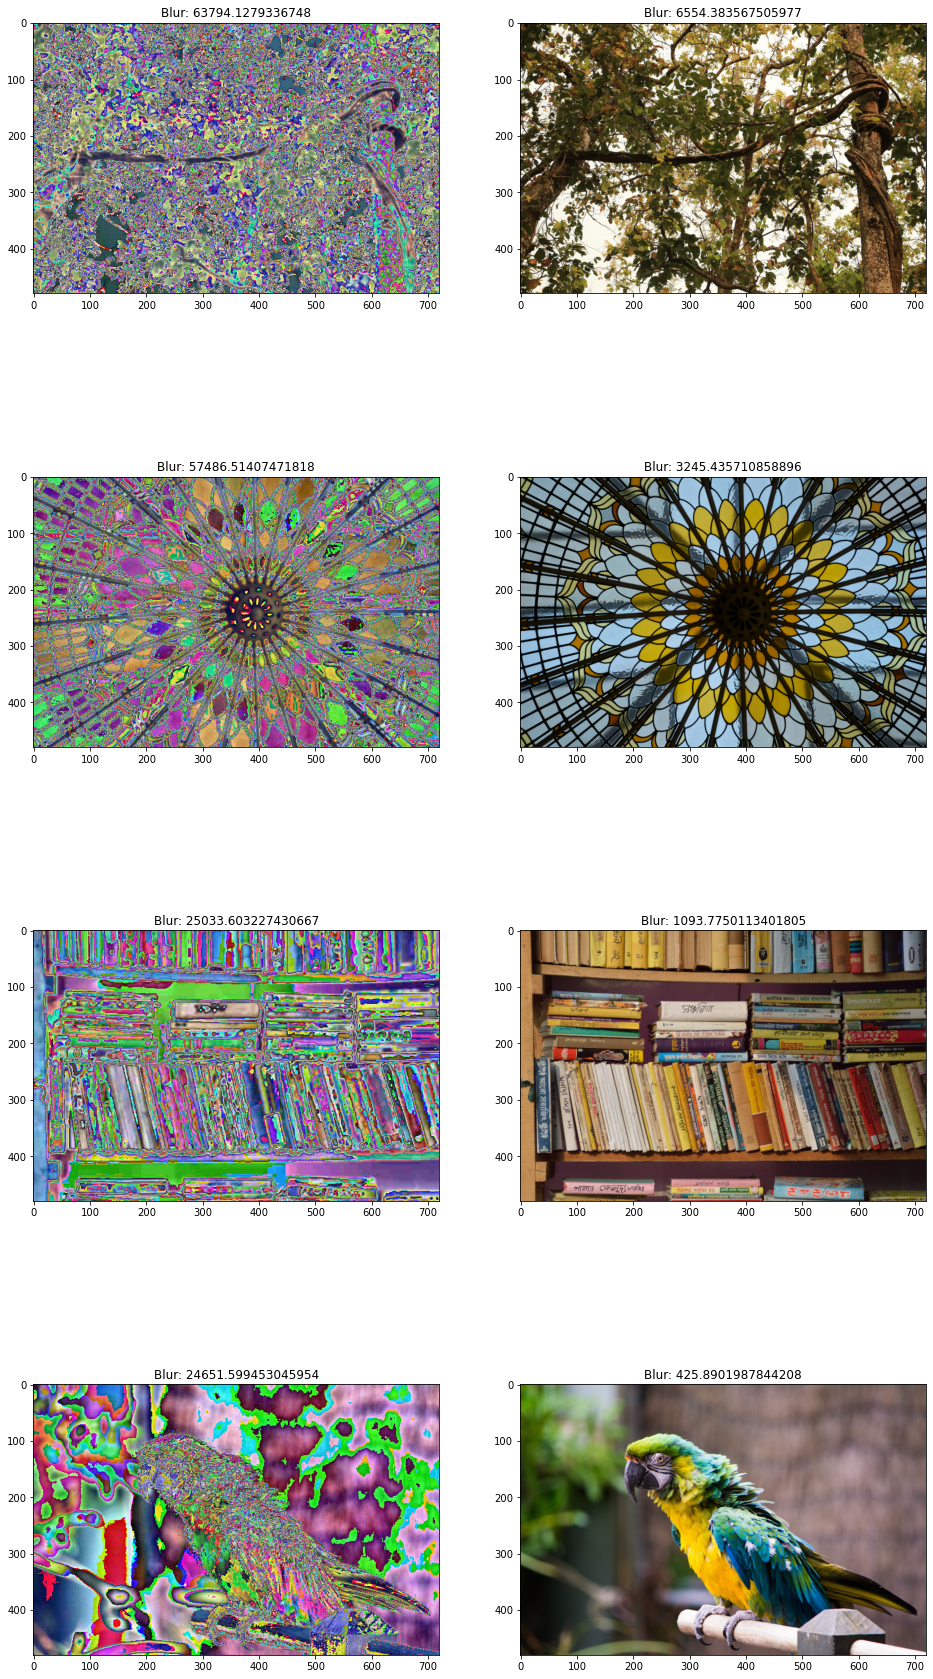

In [50]:
show_batch(valid_data_loader,size =8)

# NEW CNN for blur prediction

## Shufflenet v2

In [18]:
import torch.nn as nn
model= torch.hub.load('pytorch/vision:v0.6.0', 'shufflenet_v2_x0_5', pretrained=True)
model

Using cache found in /home/filip/.cache/torch/hub/pytorch_vision_v0.6.0


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [19]:
model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [20]:
model.fc = nn.Linear(1024, 1, bias=True)

# build the model

In [21]:
#model = NEWNet2(c1=64,c2=128)
#model = BLURNet1(c1=16,c2=64, c3=256)  ##c2 doesn't have any effect
model.cuda()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [22]:

criterion = nn.MSELoss(reduction = 'mean')

In [23]:
init_lr = .001
lr_step = 3
gradient_clip = 0.4
epochs = 18
max_kernel_scale = 17
loops = 8

In [24]:

#optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)



In [25]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [26]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [27]:
def save_checkpoint(experiment, model, epoch, valid_error):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model, "valid_error": valid_error}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [28]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [29]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [30]:
def trainfp16(training_data_loader, optimizer, scheduler, model,  epoch,scaler, loops):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    
    cum_loss = 0
    
    ct=0

    pbar = tqdm(total=loops*len(training_data_loader))
    for loopcount in range(loops):
        for iteration, batch in enumerate(training_data_loader, 1):
            inpt, target, camera_specs = batch[0], batch[1], batch[2]
            # we don't use the target for this model

            

            inpt = inpt.cuda()
            
            k_target = (camera_specs["kernel_a"].float()).cuda()

            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                k = model(inpt)
                loss = criterion(k[:,0],k_target )
                


            
            scaler.scale(loss).backward()
            #loss.backward() 

            # Unscales the gradients of optimizer's assigned params in-place
            #scaler.unscale_(optimizer)

            #nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 

            #optimizer.step()
            scaler.step(optimizer)

            if epoch>1:
                swa_model.update_parameters(model)

            # Updates the scale for next iteration.
            scaler.update()

            #scheduler.step()

            cum_loss = cum_loss + loss.data
            ct = ct +1 



            pbar.update(1)
    pbar.close()    
   
    print("Epoch kernel est loss(RMSE):", (cum_loss/ct)**(0.5))        

In [31]:
def validatefp16(valid_data_loader, model,  loop=10):

    model.eval()
    
    cum_loss = 0
    ct=0 
    
    with torch.no_grad():
        for r in trange(loop):
            for iteration, batch in enumerate(valid_data_loader, 1):
                inpt, target, camera_specs = batch[0], batch[1], batch[2]
                #we don't use the target for this model

                inpt = inpt.cuda()

                
                k_target = (camera_specs["kernel_a"].float()).cuda()
                
                # Runs the forward pass with autocasting.
                with autocast():
                    k = model(inpt)
                    loss = criterion(k[:,0],k_target)

               
                cum_loss = cum_loss + loss.data

                ct = ct + 1 ## Used to be batch_size





        print("===> Epoch Validation kernel est Loss (RMSE): {:.10f} ".format((cum_loss/ct)**(0.5) ))
    
    return (cum_loss/ct).item()

In [ ]:
#model = torch.load("/media/SSD/superres/checkpoint/NEWCNN3_epoch_54.pth")["model"]

In [ ]:
#validatefp16(valid_data_loader, model, criterion, loop=1)

f1 = "/media/SSD/superres/checkpoint/NEWCNN_epoch_"
f3 = ".pth"
lst =[]
for i in range(1,13):
    model = torch.load(f1+str(i)+f3)["model"]
    lst.append(validatefp16(valid_data_loader, model, criterion, loop=10))
    print(lst)
    
    

In [51]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, epoch,scaler,loops)
        valid_error = validatefp16(valid_data_loader, model,loop=10)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

  0%|          | 0/200 [00:00<?, ?it/s]

Start Time: 2020-10-29 10:05:14.447900
Epoch = 1, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(4.3247, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.5191317797 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_1.pth
Start Time: 2020-10-29 10:21:40.713155
Epoch = 2, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(1.2721, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 1.1705639362 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_2.pth
Start Time: 2020-10-29 10:36:29.204802
Epoch = 3, lr = 0.001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(1.1986, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.9249462485 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_3.pth
Start Time: 2020-10-29 10:51:12.991144
Epoch = 4, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(1.0753, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.7592599392 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_4.pth
Start Time: 2020-10-29 11:05:54.601132
Epoch = 5, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(1.0656, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.7228180766 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_5.pth
Start Time: 2020-10-29 11:20:34.373817
Epoch = 6, lr = 0.00031622776601683794


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(1.0295, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.6957914233 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_6.pth
Start Time: 2020-10-29 11:35:14.883621
Epoch = 7, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.9593, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.7659676671 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_7.pth
Start Time: 2020-10-29 11:49:55.297772
Epoch = 8, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.9219, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.7356171608 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_8.pth
Start Time: 2020-10-29 12:04:34.213000
Epoch = 9, lr = 0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.9562, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.6779155731 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_9.pth
Start Time: 2020-10-29 12:19:15.076460
Epoch = 10, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.9074, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.6984373331 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_10.pth
Start Time: 2020-10-29 12:33:56.979324
Epoch = 11, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.9380, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.6560074687 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_11.pth
Start Time: 2020-10-29 12:48:37.277890
Epoch = 12, lr = 3.16227766016838e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.9043, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.7525650859 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_12.pth
Start Time: 2020-10-29 13:03:15.078616
Epoch = 13, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.9208, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.6708382964 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_13.pth
Start Time: 2020-10-29 13:17:55.262409
Epoch = 14, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.8892, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.7511466146 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_14.pth
Start Time: 2020-10-29 13:32:36.535585
Epoch = 15, lr = 1.0000000000000003e-05


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.9065, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.7170715332 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_15.pth
Start Time: 2020-10-29 13:47:15.523187
Epoch = 16, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.8921, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.6737589836 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_16.pth
Start Time: 2020-10-29 14:01:56.929527
Epoch = 17, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.9366, device='cuda:0')


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch Validation kernel est Loss (RMSE): 0.6861445904 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_17.pth
Start Time: 2020-10-29 14:16:44.216264
Epoch = 18, lr = 3.16227766016838e-06


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch kernel est loss(RMSE): tensor(0.8841, device='cuda:0')


100%|██████████| 10/10 [01:53<00:00, 11.30s/it]

===> Epoch Validation kernel est Loss (RMSE): 0.6847632527 
Checkpoint saved to /media/SSD/superres/checkpoint/BLUR_SHUFFLE1_epoch_18.pth


In [ ]:
for epoch in range(19, 24+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, epoch,scaler,loops)
        valid_error = validatefp16(valid_data_loader, model,loop=10)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch, valid_error)

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [ ]:
model = torch.load("/media/SSD/superres/checkpoint/NEWCNN4_epoch_54.pth")["model"]

In [ ]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")



im_b2 = pil_disk_blur(im_gt,6)


In [ ]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1)


In [ ]:
from jupyterplot import ProgressPlot


In [ ]:
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/baby_GT_scale_4.bmp").convert("RGB")
im_gt2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT.bmp").convert("RGB")
im_b2 = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/head_GT_scale_4.bmp").convert("RGB")

In [ ]:
pp = ProgressPlot(x_iterator=False,
                  x_label="k_act",
                  x_lim=[2, 16],
                  y_lim=[[0, 16],[28,35.0],[0,30]],
                  plot_names=["kernel",'PSNR','blurryness'],
                  line_names=["pred1","pred2"])
k_act = []
k_pred = []
for k in range(2,16):
    
    kp1, err1, sharpness1 = display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False)
    kp2, err2, sharpness2 = display_PSNR(im_gt2, im_b2, pil_disk_blur(im_gt2,k), model, channels=1, display = False)
    #k_act.append(k)
    #k_pred.append(display_PSNR(im_gt, im_b, pil_disk_blur(im_gt,k), model, channels=1, display = False))
    pp.update(k,[[kp1,kp2],[err1,err2],[100/sharpness1,100/sharpness2]])
    print(k, kp1, err1,100/sharpness1)
pp.finalize()    

In [ ]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 5, model, channels = 1,display = True)

# convert sample videos

In [ ]:
from superres_utils import decolorize_cv, colorize_cv, cv_center_crop

from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,
                 bitrate= "12000k",errorfile = None, k_scale = 17, center_crop = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    if center_crop is None:
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    else:
        width,height = center_crop
    
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(errorfile,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    k_preds = []
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            #crop frame if needed
            if center_crop is not None:
                frame = cv_center_crop(frame,(height,width))
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with torch.no_grad():
                    with autocast():
                        mout = model(im_input)
                out = (mout[0]*255.0).clamp(0,255)
                
                

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = frame/255.
                im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, 3, im_input.shape[0], im_input.shape[1])
        
  
                im_input = im_input.cuda()
    
                
                
                with torch.no_grad():
                    with autocast():
                        mout = model(im_input)
                out = (mout[0]*255.0).clamp(0,255)

                out = out.cpu()
                
                im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)

                #im_h = out.data[0].numpy().astype(np.float32)

            #Add notation and crude bar chart to video frame
            
            if len(mout)>1:
                cv2.putText(im_h, text='k={:.2f}'.format(k_scale*mout[1].item()), org=(new_width-70,new_height-50),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                thickness=1, lineType=cv2.LINE_AA)
                
                cv2.putText(im_h, text='_', org=(new_width-5,new_height - int(new_height*mout[1].item())),
                fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,255),
                thickness=2, lineType=cv2.LINE_AA)
                
                
            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [ ]:
result_path

In [ ]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.6,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=2.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=3.0,display=False,bitrate= "4000k")


In [ ]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
#superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train New Network upscale PRelu L1 Div2 training/super8.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}